In [4]:
#import zipfile
#zip_ref = zipfile.ZipFile('/content/chest-ctscan-images.zip', 'r')
#zip_ref.extractall('/content')
#zip_ref.close()

#**IMPORT LIBRARIES**

In [57]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from matplotlib.image import imread
import random
import numpy as np


import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten,Dropout,BatchNormalization,Conv2D,MaxPooling2D
from keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from tensorflow.keras.utils import plot_model
from IPython.display import Image


#**VISUALISE THE DATA**

In [3]:
def images(folder_path):
    image_files = os.listdir(folder_path)
    fig, ax = plt.subplots(2, 3, figsize=(12, 4))
    for i in range(2):
        for j in range(3):
            image_path = os.path.join(folder_path, random.choice(image_files))
            image = imread(image_path)
            ax[i, j].imshow(image, cmap='gray')
            ax[i, j].axis('off')
    plt.show()

In [4]:
adenocarcinoma = '/content/drive/MyDrive/Lung cancer/Image Classification Data/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'
Largecellcarcinoma = '/content/drive/MyDrive/Lung cancer/Image Classification Data/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa'
normal = '/content/drive/MyDrive/Lung cancer/Image Classification Data/Data/train/normal'
squamouscellcarcinoma = '/content/drive/MyDrive/Lung cancer/Image Classification Data/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'


-------------------------------------------- ADENO_CARCINOMA --------------------------------------------


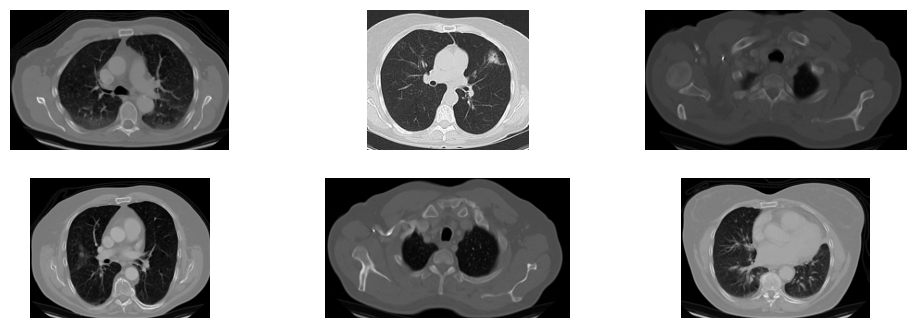

-------------------------------------------- LARGE_CELL_CARCINOMA --------------------------------------------


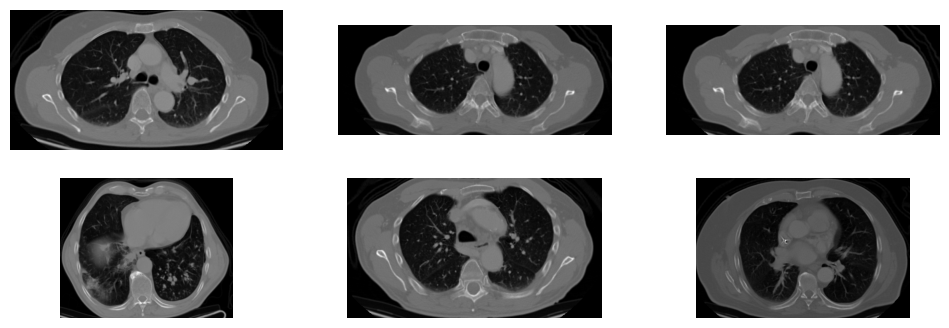

-------------------------------------------- NORMAL --------------------------------------------


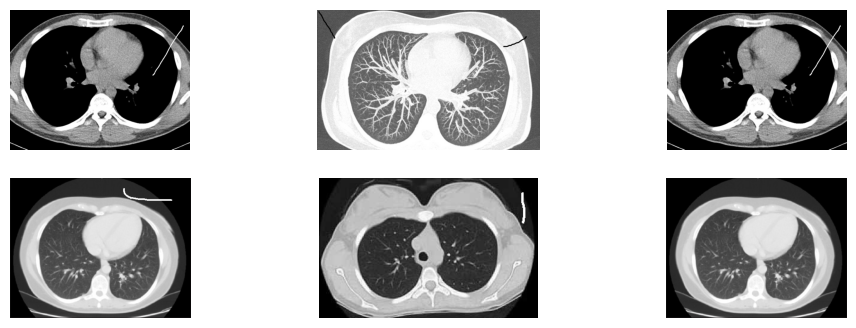

-------------------------------------------- SQUAMOUS_CELL_CARCINOMA --------------------------------------------


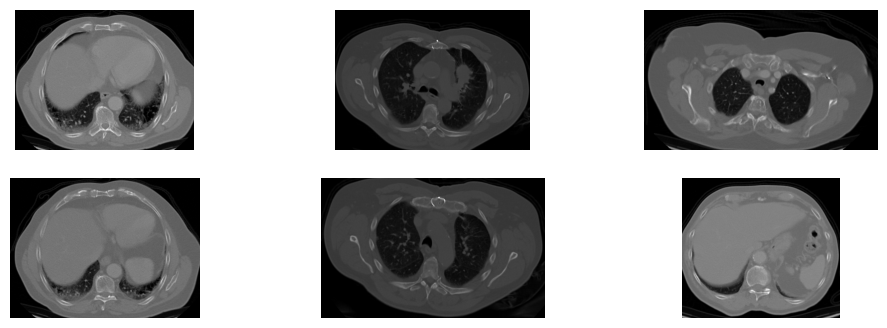

In [5]:
print("--"*22,"ADENO_CARCINOMA","--"*22)
images(adenocarcinoma)
print("--"*22,"LARGE_CELL_CARCINOMA","--"*22)
images(Largecellcarcinoma)
print("--"*22,"NORMAL","--"*22)
images(normal)
print("--"*22,"SQUAMOUS_CELL_CARCINOMA","--"*22)
images(squamouscellcarcinoma)

#**BUILD MODEL BY INCLUDING RESETNET**

In [6]:
train_path = "/content/drive/MyDrive/Lung cancer/Image Classification Data/Data/train"
valid_path = "/content/drive/MyDrive/Lung cancer/Image Classification Data/Data/test"
test_path = "/content/drive/MyDrive/Lung cancer/Image Classification Data/Data/valid"

In [7]:
train_datagen = ImageDataGenerator(
    #dtype='float32',
    preprocessing_function=None,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)
val_datagen = ImageDataGenerator(
    #dtype='float32',
    preprocessing_function=None
)
test_datagen = ImageDataGenerator(
    #dtype='float32',
    preprocessing_function=None
)

In [8]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(256,256),
    batch_size=32,
    class_mode='categorical',

)


test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(256,256),
    batch_size=32,
    class_mode='categorical',
)
validation_generator = val_datagen.flow_from_directory(
    valid_path,
    target_size=(256,256),
    batch_size=32,
    class_mode='categorical',
)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [9]:
class_names = train_generator.class_indices
print(class_names)

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1, 'normal': 2, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}


In [10]:
base_model = ResNet50(include_top=False,pooling='av',weights='imagenet',input_shape=(256,256,3))
for layer in base_model.layers:
    layer.trainable = False


94765736/94765736 [==============================] - 1s 0us/step


In [14]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 131072)            0         
                                                                 
 batch_normalization_1 (Batc  (None, 131072)           524288    
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               33554688  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                      

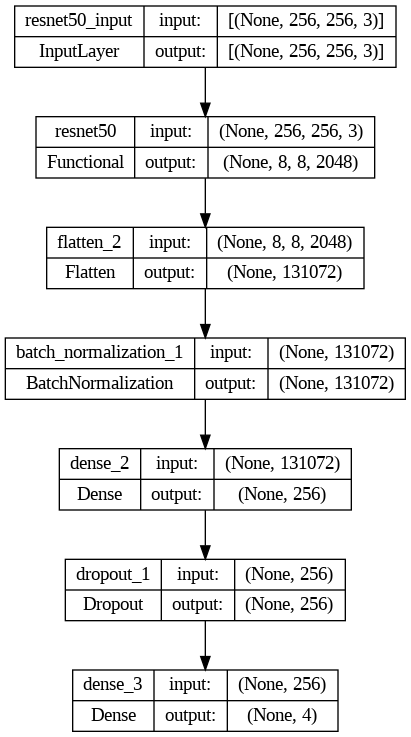

In [15]:
plot_model(model,to_file="resnet50.png",show_shapes=True,show_layer_names=True)
Image(filename="resnet50.png")

In [16]:
optimizer = tensorflow.keras.optimizers.Adam(learning_rate= 0.0001)
earlystop = EarlyStopping(patience=10,verbose=1)
checkpoint = ModelCheckpoint(filepath='Checkpoint_ResNet50.h5',monitor='val_loss',save_best_only=True,verbose=1)

In [17]:
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [18]:
history = model.fit(train_generator,validation_data=validation_generator,epochs=50,callbacks=[checkpoint, earlystop],verbose=1)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 2.4913 - accuracy: 0.4976
Epoch 1: val_loss improved from inf to 10.59110, saving model to Checkpoint_ResNet50.h5
20/20 [==============================] - 122s 6s/step - loss: 2.4913 - accuracy: 0.4976 - val_loss: 10.5911 - val_accuracy: 0.1968
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.9752 - accuracy: 0.6346
Epoch 2: val_loss improved from 10.59110 to 10.40118, saving model to Checkpoint_ResNet50.h5
20/20 [==============================] - 21s 1s/step - loss: 1.9752 - accuracy: 0.6346 - val_loss: 10.4012 - val_accuracy: 0.2032
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.6243 - accuracy: 0.6917
Epoch 3: val_loss improved from 10.40118 to 7.40113, saving model to Checkpoint_ResNet50.h5
20/20 [==============================] - 21s 1s/step - loss: 1.6243 - accuracy: 0.6917 - val_loss: 7.4011 - val_accuracy: 0.2635
Epoch 4/50
20/20 [==============================] - ETA

In [19]:
result = model.evaluate(test_generator)

3/3 [==============================] - 9s 4s/step - loss: 0.9478 - accuracy: 0.8472


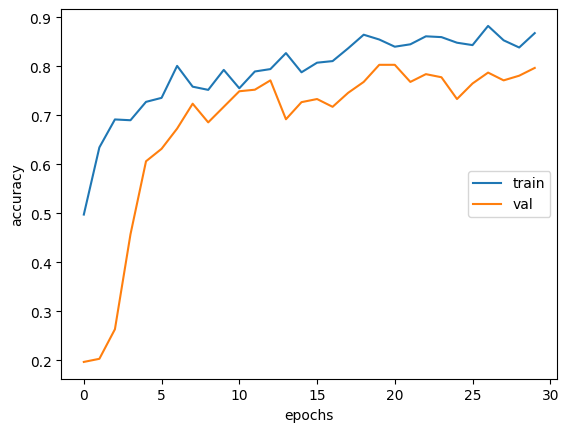

In [20]:
plt.plot(history.history['accuracy'], label = 'train',)
plt.plot(history.history['val_accuracy'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

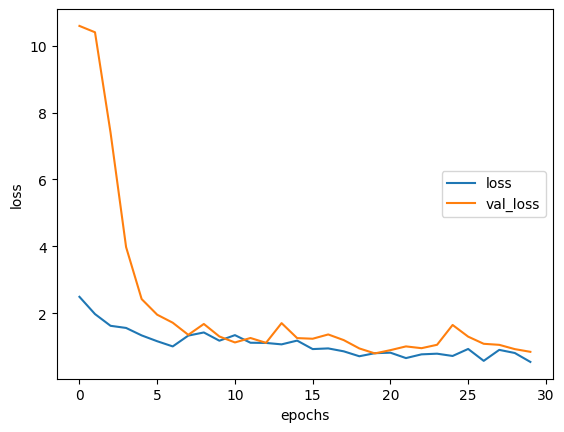

In [21]:
plt.plot(history.history['loss'], label = 'loss',)
plt.plot(history.history['val_loss'], label = 'val_loss')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [22]:
model.save('model256x256_50epochs_resnet50.keras')

In [23]:
load_model = tensorflow.keras.models.load_model('model256x256_50epochs_resnet50.keras')

In [61]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
 1: 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
 2: 'normal',
 3: 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'}

In [63]:


img_url = "/content/drive/MyDrive/Lung cancer/Image Classification Data/Data/test/normal/10 (2) - Copy.png"
#sunflower_path = tensorflow.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tensorflow.keras.utils.load_img(
    img_url, target_size=(256,256)
)
img_array = tensorflow.keras.utils.img_to_array(img)
img_array = tensorflow.expand_dims(img_array, 0) # Create a batch

predictions = load_model.predict(img_array)
score = tensorflow.nn.softmax(predictions[0])
score_max=np.argmax(score)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels.get(score_max), 100 * np.max(score))
)

1/1 [==============================] - 0s 76ms/step
This image most likely belongs to normal with a 47.54 percent confidence.
